### Survival analysis and an investigation into the poor performance of machine learning

Set export to True if you wish to export graphs

In [1]:
export = True

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from auxiliary_code.helper_functions import *
from scipy import stats
import statsmodels.api as sm
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from itertools import product

In [3]:
df_wb = pd.read_csv(
    '../datasets/world_bank_processed.csv', parse_dates=['date'])
set_index(df_wb)

# rain anomalies normalize
df_wb['rain_anom_norm'] = df_wb['rain_anom'].groupby('area').apply(lambda x: ((x - x.mean())/x.std()))
rain_anom = df_wb['rain_anom_norm'].copy()
# rolling windows
df_wb['rain_anom_rolling'] = df_wb['rain_anom_norm'].groupby('area').rolling(12).mean().droplevel(0)
df_wb['ndvi_std_rolling'] = df_wb['ndvi_mean'].groupby('area').rolling(12).std().droplevel(0)
df_wb['ndvi_std_rolling'] = df_wb['ndvi_std_rolling'].groupby('area').apply(lambda x: ((x - x.mean())/x.std()))
df_wb['p_food_l12'] = df_wb['p_staple_food'].groupby('area').shift(12)
df_wb['delta_p_staple_food'] = df_wb['p_staple_food'] - df_wb['p_food_l12'] 
df_wb['delta_p_staple_food'] = df_wb['delta_p_staple_food'].groupby('area').apply(lambda x: ((x - x.mean())/x.std()))

# tails of distributions
df_wb['food_tail'] = df_wb['delta_p_staple_food'] > df_wb['delta_p_staple_food'].quantile(.95)
df_wb['rain_tail'] = df_wb['rain_anom_rolling'] < df_wb['rain_anom_rolling'].quantile(.05)
df_wb['food_rain_tail'] = df_wb['food_tail'] & df_wb['food_tail']

# shifted data
df_wb['rain_anom_rolling_shifted'] = df_wb['rain_anom_rolling'].shift(5)
df_wb['delta_p_staple_food_shifted'] = df_wb['delta_p_staple_food'].shift(5)
df_wb['int'] = df_wb['rain_anom_rolling_shifted']  * df_wb['delta_p_staple_food_shifted']



fews_ipc = df_wb['fews_ipc'].dropna()
fews_ipc_l1 = fews_ipc.groupby('area').shift(1)

crisis = (fews_ipc >= 3) & (fews_ipc_l1 == 2)
no_crisis = (fews_ipc == 2) & (fews_ipc_l1 == 2)

df_wb = df_wb.join(crisis.rename('crisis'))
df_wb = df_wb.join(no_crisis.rename('no_crisis'))

mask = df_wb['crisis'].isna() & df_wb['no_crisis'].isna()
mask = ~mask & (df_wb['crisis'] + df_wb['no_crisis'] > 0)

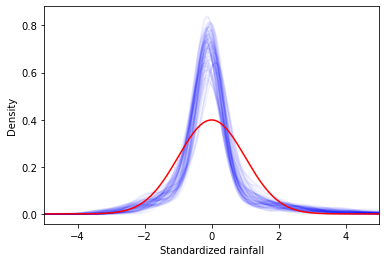

In [4]:
fig, ax = plt.subplots()
rain_anom.groupby('area').plot(kind='kde', ax=ax, alpha=0.05, color='blue');
x = np.linspace(-5, 5, 1000)
plt.plot(x, stats.norm.pdf(x), color='red');
plt.xlim((-5, 5))
ax.set_xlabel('Standardized rainfall')

if export:
    fig.savefig('../figures/rainfall_kurtosis.pdf', format='pdf')

In [5]:
X = df_wb[mask].copy()
X = X.dropna(subset='rain_anom_rolling_shifted')
y = X['crisis'].astype('float32')

X = sm.add_constant(X[['rain_anom_rolling_shifted', 'delta_p_staple_food_shifted', 'int']])
reg = sm.Logit(y, X).fit(cov_type='hc0')
reg.summary()

Optimization terminated successfully.
         Current function value: 0.290257
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 crisis   No. Observations:                 1625
Model:                          Logit   Df Residuals:                     1621
Method:                           MLE   Df Model:                            3
Date:                Sat, 06 Aug 2022   Pseudo R-squ.:                 0.09387
Time:                        20:18:20   Log-Likelihood:                -471.67
converged:                       True   LL-Null:                       -520.53
Covariance Type:                  hc0   LLR p-value:                 4.805e-21
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -2.2509      0.094    -24.065      0.000      -2.434      -2.068
rain_anom_rolling_shifted      -2.8919      0.360     -8.028      0.000      -3.598      -2.186
delta_p_staple_food_shifted     0.6095      0.126      4.835      0.000       0.362       0.857
int                             0.8385      0.484      1.733      0.083      -0.110       1.787
===============================================================================================
"""

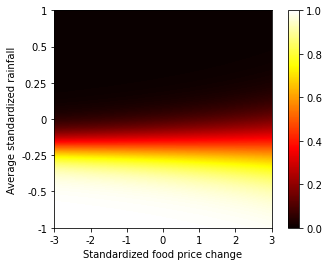

In [6]:
N = 1000
x_range_rain = np.linspace(-3, 3, N)
x_range_prices = np.linspace(-1, 1, N)

im = np.array(list(product([1], x_range_rain, x_range_prices)))
im = np.concatenate([im, im[:, 1:].prod(axis=1).reshape(-1, 1)], axis=1)
probs = reg.predict(im)

fig, ax = plt.subplots()

im  = ax.imshow(probs.reshape((N, N)), cmap='hot', interpolation='nearest', origin='lower', vmin=0, vmax=1)
ax.set_xticks(np.linspace(0, 1000, 7))
ax.set_yticks(np.linspace(0, 1000, 7))
ax.set_xticklabels([-3, -2, -1, 0, 1, 2, 3])
ax.set_yticklabels([-1, -0.5, -0.25, 0, 0.25, 0.5, 1])
ax.set_xlabel('Standardized food price change')
ax.set_ylabel('Average standardized rainfall')

plt.colorbar(im)

if export:
    fig.savefig('../figures/logistic_reg_rain_prices.pdf', format='pdf')

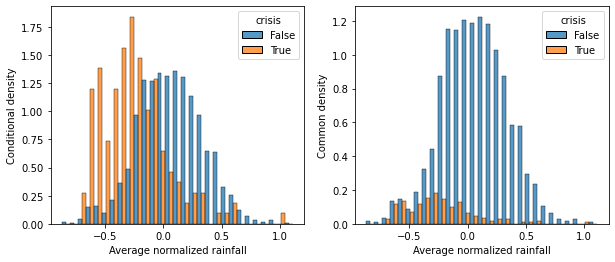

In [7]:
X = df_wb[mask].copy()
X = X.dropna(subset='rain_anom_rolling')

fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
sns.histplot(X, x="rain_anom_rolling", hue="crisis", multiple="dodge", common_norm=False, stat="density", ax=axs[0])
sns.histplot(X, x="rain_anom_rolling", hue="crisis", multiple="dodge", common_norm=True, stat="density", ax=axs[1])

for i in range(2):
    axs[i].set_xlabel('Average normalized rainfall')

axs[0].set_ylabel('Conditional density')
axs[1].set_ylabel('Common density');

if export:
    fig.savefig('../figures/cond_vs_comm_density_rainfall.pdf', format='pdf')

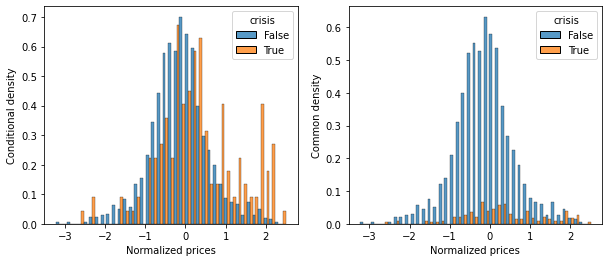

In [8]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))

sns.histplot(X, x="delta_p_staple_food", hue="crisis", multiple="dodge", common_norm=False, stat="density", ax=axs[0])
sns.histplot(X, x="delta_p_staple_food", hue="crisis", multiple="dodge", common_norm=True, stat="density", ax=axs[1])

for i in range(2):
    axs[i].set_xlabel('Normalized prices')

axs[0].set_ylabel('Conditional density')
axs[1].set_ylabel('Common density');

if export:
    fig.savefig('../figures/cond_vs_comm_density_prices.pdf', format='pdf')

In [9]:
print(X.groupby('crisis')['food_rain_tail'].agg(['mean', 'sum']).style.to_latex())

\begin{tabular}{lrr}
 & mean & sum \\
crisis &  &  \\
False & 0.006139 & 9 \\
True & 0.075472 & 12 \\
\end{tabular}



In [10]:
df_wb = pd.read_csv(
    '../datasets/world_bank_processed.csv', parse_dates=['date'])
set_index(df_wb)
df_wb['rain_anom_norm'] = df_wb['rain_anom'].groupby('area').apply(lambda x: ((x - x.mean())/x.std()))
rain_anom = df_wb['rain_anom_norm'].copy()
df_wb['rain_anom_rolling'] = df_wb['rain_anom_norm'].groupby('area').rolling(12).mean().droplevel(0)
df_wb['ndvi_std_rolling'] = df_wb['ndvi_mean'].groupby('area').rolling(12).std().droplevel(0)
df_wb['ndvi_std_rolling'] = df_wb['ndvi_std_rolling'].groupby('area').apply(lambda x: ((x - x.mean())/x.std()))
df_wb['p_food_l12'] = df_wb['p_staple_food'].groupby('area').shift(12)
df_wb['delta_p_staple_food'] = df_wb['p_staple_food'] - df_wb['p_food_l12'] 
df_wb['delta_p_staple_food'] = df_wb['delta_p_staple_food'].groupby('area').apply(lambda x: ((x - x.mean())/x.std()))

df_wb['food_tail'] = df_wb['delta_p_staple_food'] > df_wb['delta_p_staple_food'].quantile(.80)
df_wb['rain_tail'] = df_wb['rain_anom_rolling'] < df_wb['rain_anom_rolling'].quantile(.20)
df_wb['food_rain_tail'] = df_wb['food_tail'] & df_wb['food_tail']

df_ipc = pd.read_csv(
    '../datasets/ipc_processed.csv', parse_dates=['date'])
set_index(df_ipc)
df_ipc = df_ipc['phase3plus_perc']
df_wb = df_wb.join(df_ipc)
df_wb.dropna(subset='phase3plus_perc');

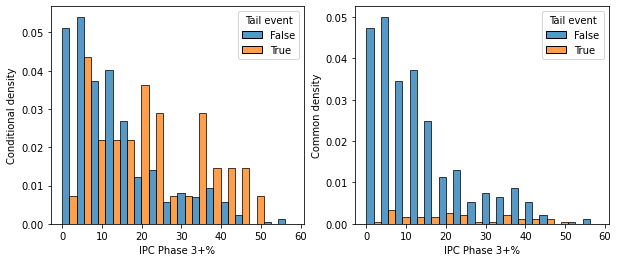

In [11]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 4))
df_wb['Tail event'] = df_wb['food_rain_tail']
df_wb['phase3plus_perc'] = df_wb['phase3plus_perc']*100
sns.histplot(df_wb, x="phase3plus_perc", hue='Tail event', multiple="dodge", common_norm=False, stat="density", ax=axs[0])
sns.histplot(df_wb, x="phase3plus_perc", hue='Tail event', multiple="dodge", common_norm=True, stat="density", ax=axs[1])

for i in range(2):
    axs[i].set_xlabel('IPC Phase 3+%')

axs[0].set_ylabel('Conditional density')
axs[1].set_ylabel('Common density');

if export:
    fig.savefig('../figures/cond_vs_comm_density_ipc_perc.pdf', format='pdf')

In [12]:
df_wb = pd.read_csv(
    '../datasets/world_bank_processed.csv', parse_dates=['date'])
set_index(df_wb)

df_wb.sort_index(inplace=True)
df_wb['rain_anom_norm'] = df_wb['rain_anom'].groupby('area').apply(lambda x: ((x - x.mean())/x.std()))
df_wb['rain_anom_rolling'] = df_wb['rain_anom_norm'].groupby('area').rolling(12).mean().droplevel(0)
df_wb['delta_prices'] = df_wb['p_staple_food'] - df_wb['p_staple_food'].groupby('area').shift(1)

df_wb.dropna(subset='fews_ipc', inplace=True)
df_wb.sort_index(inplace=True)

In [13]:
def months_since_start(x):
    start = x['date'].min()
    start_months = start.year * 12 + start.month
    return x['date'].dt.year * 12 + x['date'].dt.month - start_months
df_wb['months'] = df_wb.reset_index().groupby('area').apply(months_since_start).to_numpy()

In [14]:
N = get_date(df_wb).nunique()
lags = np.zeros((N + 1, len(df_wb)), dtype='float32')
times = np.zeros((N + 1, len(df_wb)), dtype='float32')
rainfall = np.zeros((N + 1, len(df_wb)), dtype='float32')
prices = np.zeros((N + 1, len(df_wb)), dtype='float32')
conflict = np.zeros((N + 1, len(df_wb)), dtype='float32')
for lag in range(N + 1):
    lags[lag] = df_wb.groupby('area').apply(lambda x:  x['fews_ipc'].shift(lag)).astype('float32').to_numpy()
    times[lag] = df_wb.groupby('area').apply(lambda x:  x['months'].shift(lag)).astype('float32').to_numpy()
    rainfall[lag] = df_wb.groupby('area').apply(lambda x:  x['rain_anom_norm'].shift(lag)).astype('float32').to_numpy()
    prices[lag] = df_wb.groupby('area').apply(lambda x:  x['delta_prices'].shift(lag)).astype('float32').to_numpy()
    prices[lag] = df_wb.groupby('area').apply(lambda x:  x['delta_prices'].shift(lag)).astype('float32').to_numpy()

In [15]:
survival_times = []
status = []
rainfalls = []
price_data = []
conflicts = []
left_censored = []
south = []
rainfall_dist = []
for idx, l in enumerate(lags.T):
    rc = False
    # still surviving
    if l[0] < 2.9 and np.isnan(l).sum() > 1:
        survival_times.append(0)
        status.append(-1)
        rainfalls.append(-100)
        price_data.append(-1)
        conflicts.append(-1)
        south.append(df_wb.iloc[idx]['centy'] < 5)
        continue
    
    # right-censored
    if l[0] < 2.9 and np.isnan(l).sum() == 1:
        rc = True
        
    if not rc:
        # if we are here then we are now in a critical state
        if l[1] > 2.9:
            survival_times.append(0)
            status.append(-1)
            rainfalls.append(-100)
            price_data.append(-1)
            conflicts.append(-1)
            south.append(df_wb.iloc[idx]['centy'] < 5)
            continue
    
    for i in range(1, len(l)):
        # left-censored
        if np.isnan(l[i]):
            survival_times.append(times.T[idx][0] - times.T[idx][i-1])
            rainfalls.append(rainfall.T[idx][0:i].mean())
            price_data.append(prices.T[idx][0:i].mean())
            conflicts.append(conflict.T[idx][0:i].mean())
            status.append(-1)
            south.append(df_wb.iloc[idx]['centy'] < 5)
            break
        # end of spell
        elif l[i] >= 2.9:
            survival_times.append(times.T[idx][0] - times.T[idx][i])
            rainfalls.append(rainfall.T[idx][0:i+1].mean())
            price_data.append(prices.T[idx][0:i+1].mean())
            conflicts.append(conflict.T[idx][0:i+1].mean())
            south.append(df_wb.iloc[idx]['centy'] < 5)
            rainfall_dist.append([rainfall.T[idx][0:i+1].mean(), times.T[idx][0] - times.T[idx][i]])
            if rc:
                status.append(0)
            else:
                status.append(1)
            break
        rainfall_dist.append([rainfall.T[idx][0:i+1].mean(), times.T[idx][0] - times.T[idx][i]])

        
            
survival_times = np.array(survival_times)
status = np.array(status)
rainfalls = np.array(rainfalls)
price_data = np.array(price_data)
conflicts = np.array(conflicts)
south = np.array(south).astype('bool')
rainfall_dist = np.array(rainfall_dist)

In [16]:
# remove 'still surviving but not right-censored'
mask = status >= -0.1
status = status[mask]
survival_times = survival_times[mask]
rainfalls = rainfalls[mask]
price_data = price_data[mask]
conflicts = conflicts[mask]
south = south[mask]

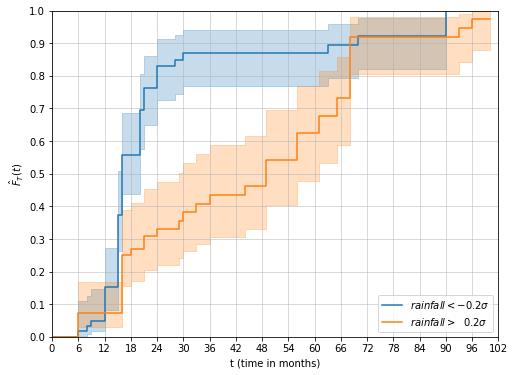

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

kmf = KaplanMeierFitter()

rain_mask_low =  (rainfalls < -0.2)
rain_mask_high = (rainfalls > 0.2)

kmf.fit(durations = survival_times[rain_mask_low], event_observed = status[rain_mask_low], label='$rainfall < -0.2\\sigma$')
kmf.plot_cumulative_density() 

kmf.fit(durations = survival_times[rain_mask_high], event_observed = status[rain_mask_high], label='$rainfall >$' + '  ' + '$0.2\\sigma$')
kmf.plot_cumulative_density() 

ax.set_xlim(0, 102)
ax.set_ylim(0, 1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, 108, 6))
ax.set_xlabel('t (time in months)')
ax.set_ylabel(r'$\hat{F}_{T}(t)$')
ax.grid(alpha=0.6)
ax.legend(loc='lower right')

if export:
    fig.savefig('../figures/low_vs_med_rainfall_cdf.pdf', format='pdf')